In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False


RAW_DIR = Path("data/raw")   # 너 폴더에 맞게 수정

def read_csv_safely(path: Path, **kwargs) -> pd.DataFrame:
    encodings = ["utf-8-sig", "cp949", "euc-kr", "utf-8"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except Exception as e:
            last_err = e
    raise last_err


In [4]:
pattern = "사고분석"  # 파일명에 들어가는 공통 키워드로 수정 가능
paths = sorted(RAW_DIR.glob(f"*{pattern}*.csv"))
paths

dfs = []
for p in paths:
    df = read_csv_safely(p)
    df.columns = df.columns.str.strip()
    df["source_file"] = p.name
    dfs.append(df)

acc = pd.concat(dfs, ignore_index=True)
acc.shape, acc["source_file"].nunique()



C:\Users\human-34\AppData\Local\Temp\ipykernel_1256\1375157200.py:23: DtypeWarning: Columns (0,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, encoding=enc, **kwargs)


((394646, 23), 2)

In [5]:
acc.head()



,구분번호,발생년월,주야,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,...,도로형태,가해운전자 차종,가해운전자 성별,가해운전자 연령대,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령대,피해운전자 상해정도,source_file
0,2023000001,2023년 1월,야간,서울특별시 성동구,경상사고,0,0,2,0,차대차 - 기타,...,교차로 - 교차로안,승용,남,65세 이상,상해없음,승합,남,51-60세,경상,사고분석-23년.csv
1,2023000002,2023년 1월,야간,서울특별시 관악구,경상사고,0,0,1,0,차대차 - 충돌,...,교차로 - 교차로안,승용,남,65세 이상,상해없음,승용,남,31-40세,경상,사고분석-23년.csv
2,2023000016,2023년 1월,야간,서울특별시 은평구,중상사고,0,1,0,0,차대사람 - 기타,...,단일로 - 기타,승용,남,51-60세,상해없음,보행자,남,61-64세,중상,사고분석-23년.csv
3,2023000030,2023년 1월,야간,서울특별시 성북구,중상사고,0,1,0,0,차대차 - 충돌,...,교차로 - 교차로안,이륜,남,31-40세,상해없음,이륜,남,31-40세,중상,사고분석-23년.csv
4,2023000031,2023년 1월,야간,서울특별시 동작구,경상사고,0,0,1,0,차대차 - 기타,...,단일로 - 기타,승용,남,31-40세,상해없음,이륜,여,21-30세,경상,사고분석-23년.csv


In [6]:
acc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394646 entries, 0 to 394645
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   구분번호         394646 non-null  object
 1   발생년월         394646 non-null  object
 2   주야           394646 non-null  object
 3   시군구          394646 non-null  object
 4   사고내용         394646 non-null  object
 5   사망자수         394646 non-null  object
 6   중상자수         394646 non-null  object
 7   경상자수         394646 non-null  object
 8   부상신고자수       394646 non-null  object
 9   사고유형         394646 non-null  object
 10  법규위반         394646 non-null  object
 11  노면상태         394646 non-null  object
 12  기상상태         394646 non-null  object
 13  도로형태         394646 non-null  object
 14  가해운전자 차종     394646 non-null  object
 15  가해운전자 성별     394646 non-null  object
 16  가해운전자 연령대    394646 non-null  object
 17  가해운전자 상해정도   394646 non-null  object
 18  피해운전자 차종     378319 non-null  object
 19  피해

In [7]:
summary = pd.DataFrame({
    "dtype" : acc.dtypes.astype(str),
    "missing" : acc.isna().sum(),
    "missing_rate" : (acc.isna().mean()*100).round(2),
    "n_unique" : acc.nunique(dropna=True)
}).sort_values("missing_rate",ascending=False)

summary

,dtype,missing,missing_rate,n_unique
피해운전자 상해정도,object,16327,4.14,7
피해운전자 연령대,object,16327,4.14,10
피해운전자 성별,object,16327,4.14,4
피해운전자 차종,object,16327,4.14,14
구분번호,object,0,0.00,394646
발생년월,object,0,0.00,25
주야,object,0,0.00,3
중상자수,object,0,0.00,29
사망자수,object,0,0.00,13
사고내용,object,0,0.00,5


In [8]:
def _to_int_series(s: pd.Series) -> pd.Series:
    # "1,234" 같은 문자열도 숫자로
    return pd.to_numeric(
        s.astype(str).str.replace(",", "", regex=False),
        errors="coerce"
    ).fillna(0).astype(int)

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    발생년월: '2023년 1월' 형태에서 발생년/발생월 파생
    """
    out = df.copy()
    if "발생년월" in out.columns:
        # 연도
        year = out["발생년월"].astype(str).str.extract(r"(\d{4})")[0]
        out["발생년"] = pd.to_numeric(year, errors="coerce").fillna(-1).astype(int)

        # 월
        month = out["발생년월"].astype(str).str.extract(r"(\d{1,2})\s*월")[0]
        out["발생월"] = pd.to_numeric(month, errors="coerce").fillna(-1).astype(int)
    else:
        out["발생년"] = -1
        out["발생월"] = -1

    # -1(파싱 실패) 제거/보정은 필요하면 여기서
    return out

def add_targets(df: pd.DataFrame) -> pd.DataFrame:
    """
    중대사고 = (사망자수 + 중상자수) >= 1
    """
    out = df.copy()

    for c in ["사망자수", "중상자수", "경상자수", "부상신고자수"]:
        if c in out.columns:
            out[c] = _to_int_series(out[c])

    if "사망자수" in out.columns and "중상자수" in out.columns:
        out["중대사고"] = ((out["사망자수"] + out["중상자수"]) >= 1).astype(int)
    else:
        raise KeyError("타겟 생성에 필요한 컬럼(사망자수/중상자수)이 없습니다.")

    # 참고용 총피해자수
    if all(c in out.columns for c in ["사망자수", "중상자수", "경상자수", "부상신고자수"]):
        out["총피해자수"] = out["사망자수"] + out["중상자수"] + out["경상자수"] + out["부상신고자수"]

    return out

def fill_missing_unknown(df: pd.DataFrame) -> pd.DataFrame:
    """
    피해운전자 관련 결측치는 '미상'으로 대체 (너가 추가한 로직 반영)
    """
    out = df.copy()
    missing_cols = [
        "피해운전자 연령대",
        "피해운전자 성별",
        "피해운전자 차종",
    ]
    for c in missing_cols:
        if c in out.columns:
            out[c] = out[c].fillna("미상")
    return out

def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    """
    공백 정리 + 문자열 컬럼 정리(앞뒤 공백)
    """
    out = df.copy()

    # 컬럼명 공백 제거(혹시 모를 케이스)
    out.columns = [c.strip() for c in out.columns]

    # object 컬럼 앞뒤 공백 제거
    obj_cols = out.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        out[c] = out[c].astype(str).str.strip()

    return out

def preprocess_all(df: pd.DataFrame) -> pd.DataFrame:
    """
    전체 전처리 파이프라인
    """
    df = basic_clean(df)
    df = add_time_features(df)
    df = add_targets(df)
    df = fill_missing_unknown(df)
    return df

acc = preprocess_all(acc)

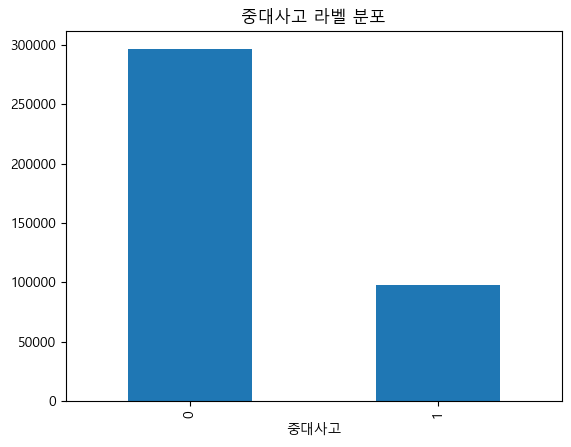

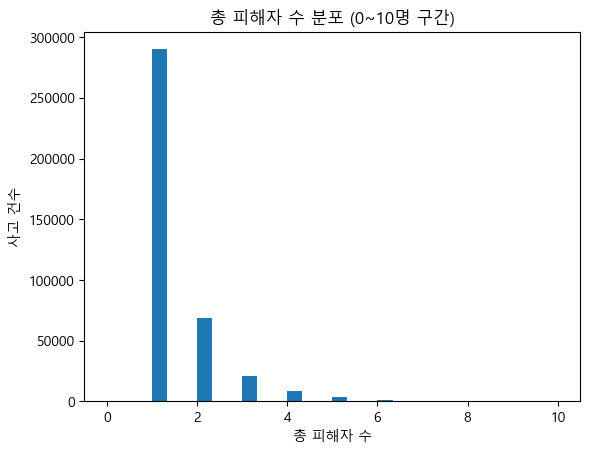

In [9]:
fig, ax = plt.subplots()
acc["중대사고"].value_counts().plot(kind="bar", ax=ax, title="중대사고 라벨 분포")
plt.show()

fig, ax = plt.subplots()
ax.hist(acc["총피해자수"], bins=30, range=(0, 10))
ax.set_title("총 피해자 수 분포 (0~10명 구간)")
ax.set_xlabel("총 피해자 수")
ax.set_ylabel("사고 건수")
plt.show()




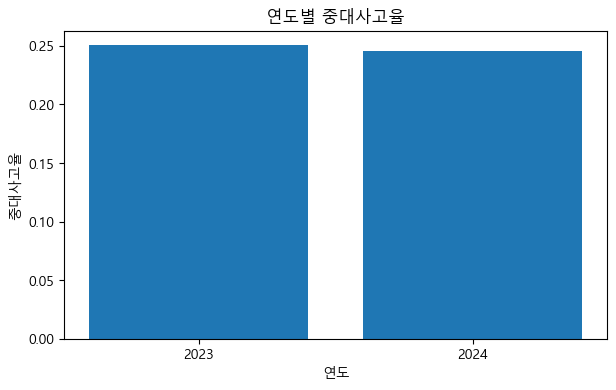

In [10]:
acc_valid = acc[acc["발생년"] > 0].copy()

yearly = acc_valid.groupby("발생년").agg(
    n=("구분번호","count"),
    severe_rate=("중대사고","mean"),
).reset_index().sort_values("발생년")

plt.figure(figsize=(7,4))
plt.bar(yearly["발생년"], yearly["severe_rate"])
plt.xticks(yearly["발생년"])
plt.title("연도별 중대사고율")
plt.xlabel("연도")
plt.ylabel("중대사고율")
plt.show()



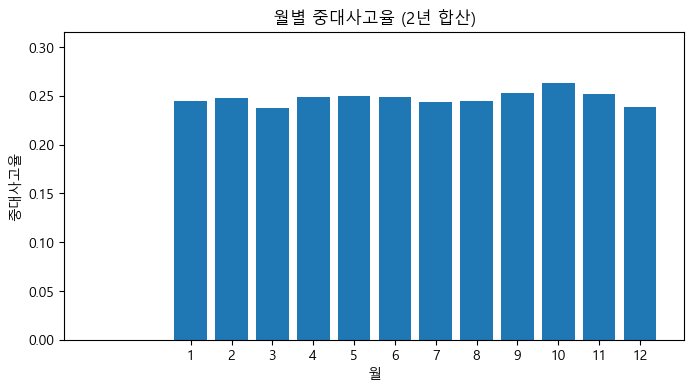

In [11]:
# 월별 중대사고율(연도 섞어서)
monthly = acc.groupby("발생월").agg(
    n=("구분번호","count"),
    severe_rate=("중대사고","mean"),
).reset_index().sort_values("발생월")

plt.figure(figsize=(8,4))
plt.bar(monthly["발생월"], monthly["severe_rate"])
plt.title("월별 중대사고율 (2년 합산)")
plt.xlabel("월")
plt.ylabel("중대사고율")
plt.xticks(range(1,13))
plt.ylim(0, monthly["severe_rate"].max() * 1.2)
plt.show()




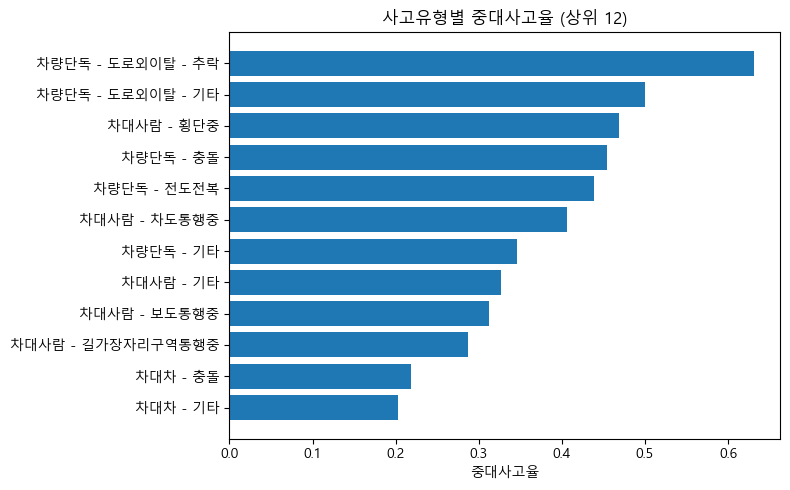

In [14]:
def severe_rate_by(df: pd.DataFrame, col: str, target="중대사고", min_count=50) -> pd.DataFrame:
    tmp = df.groupby(col)[target].agg(["count", "mean"]).reset_index()
    tmp = tmp[tmp["count"] >= min_count].sort_values("mean", ascending=False)
    tmp = tmp.rename(columns={"mean": "severe_rate"})
    return tmp


rate_df = severe_rate_by(acc, "사고유형", target="중대사고", min_count=50)


if len(rate_df) > 0:
    topn = 12
    plot_df = rate_df.head(topn).sort_values("severe_rate")
    plt.figure(figsize=(8, 5))
    plt.barh(plot_df["사고유형"].astype(str), plot_df["severe_rate"])
    plt.title(f"사고유형별 중대사고율 (상위 {topn})")
    plt.xlabel("중대사고율")
    plt.tight_layout()
    plt.show()



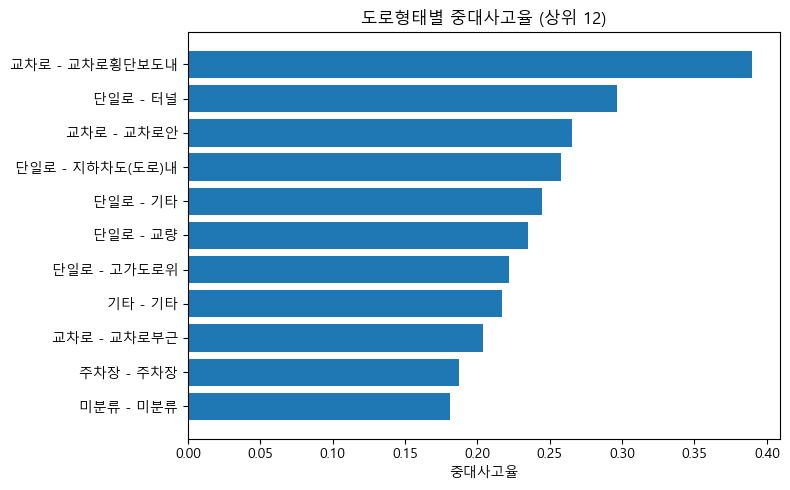

In [17]:
rate_df = severe_rate_by(acc, "도로형태", target="중대사고", min_count=50)

topn = 12
plot_df = rate_df.head(topn).sort_values("severe_rate")
plt.figure(figsize=(8, 5))
plt.barh(plot_df["도로형태"].astype(str), plot_df["severe_rate"])
plt.title(f"도로형태별 중대사고율 (상위 {topn})")
plt.xlabel("중대사고율")
plt.tight_layout()
plt.show()

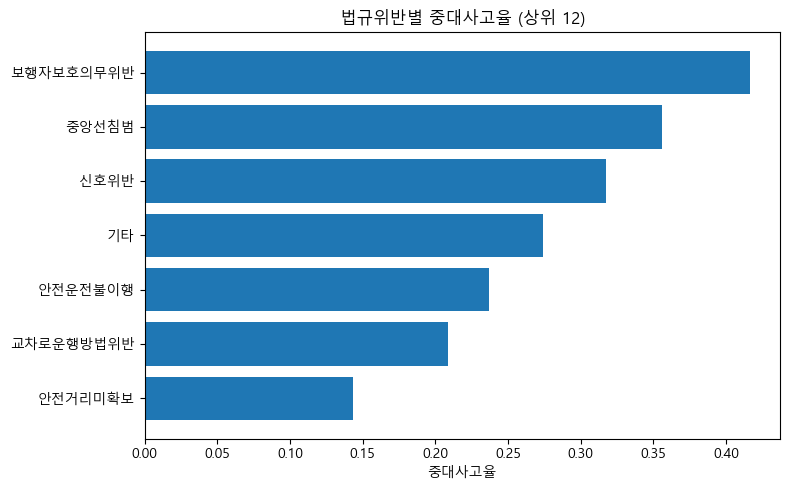

In [18]:
rate_df = severe_rate_by(acc, "법규위반", target="중대사고", min_count=50)

topn = 12
plot_df = rate_df.head(topn).sort_values("severe_rate")
plt.figure(figsize=(8, 5))
plt.barh(plot_df["법규위반"].astype(str), plot_df["severe_rate"])
plt.title(f"법규위반별 중대사고율 (상위 {topn})")
plt.xlabel("중대사고율")
plt.tight_layout()
plt.show()


In [20]:
TARGET_COL = "중대사고"

DEFAULT_FINAL_COLS = [
    "사고유형",
    "법규위반",
    "가해운전자 차종",
    "도로형태",
    "가해운전자 연령대",
]

# (선택) 보조 변수 쓰고 싶으면 추가
OPTIONAL_COLS = ["주야", "노면상태", "기상상태", "가해운전자 성별"]

use_optional = False  # True로 바꾸면 보조 변수 포함
feature_cols = DEFAULT_FINAL_COLS + OPTIONAL_COLS if use_optional else DEFAULT_FINAL_COLS

# 실제 데이터에 존재하는 것만 사용
feature_cols = [c for c in feature_cols if c in acc.columns]
feature_cols


['사고유형', '법규위반', '가해운전자 차종', '도로형태', '가해운전자 연령대']

In [22]:
X = acc[feature_cols].copy()
y = acc[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

def build_pipeline(model, cat_cols):
    preprocess = ColumnTransformer(
        transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)]
    )
    return Pipeline([("preprocess", preprocess), ("model", model)])


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

def evaluate_binary(model, X_test, y_test):
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            proba = None

    return {
        "accuracy": float(accuracy_score(y_test, pred)),
        "precision": float(precision_score(y_test, pred, zero_division=0)),
        "recall": float(recall_score(y_test, pred, zero_division=0)),
        "f1": float(f1_score(y_test, pred, zero_division=0)),
        "auc": float(roc_auc_score(y_test, proba)) if proba is not None else float("nan"),
        "confusion_matrix": confusion_matrix(y_test, pred),
    }

# ---- 모델 정의(=Streamlit과 동일 컨셉) ----
lr = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)  # :contentReference[oaicite:5]{index=5}
rf = RandomForestClassifier(
    n_estimators=200, max_depth=12, min_samples_leaf=50,
    class_weight="balanced", random_state=42, n_jobs=-1
)  # :contentReference[oaicite:6]{index=6}

models = [
    ("LogisticRegression", lr),
    ("RandomForest", rf),
]

# (선택) XGBoost 있으면 추가
try:
    from xgboost import XGBClassifier
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    scale_pos_weight = neg / max(pos, 1)

    xgb = XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=42
    )  # :contentReference[oaicite:7]{index=7}
    models.append(("XGBoost", xgb))
except Exception:
    print("XGBoost 미설치/불가로 스킵 (원하면: pip install xgboost)")

# ---- 학습/평가 ----
results = []
for name, model in models:
    pipe = build_pipeline(model, feature_cols)
    pipe.fit(X_train, y_train)
    m = evaluate_binary(pipe, X_test, y_test)
    results.append((name, pipe, m))

# ---- 결과 테이블 ----
rows = []
for name, _, m in results:
    rows.append({
        "model": name,
        "accuracy": m["accuracy"],
        "precision": m["precision"],
        "recall": m["recall"],
        "f1": m["f1"],
        "auc": m["auc"],
    })

res_df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
res_df




,model,accuracy,precision,recall,f1,auc
0,XGBoost,0.629951,0.353777,0.595677,0.443911,0.658378
1,RandomForest,0.636805,0.356602,0.577896,0.441047,0.656493
2,LogisticRegression,0.637362,0.354160,0.561596,0.434384,0.652219


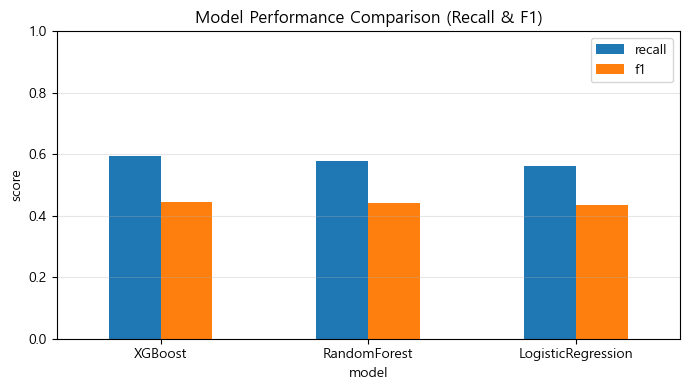

In [24]:
plot_df = res_df.set_index("model")[["recall", "f1"]]
ax = plot_df.plot(kind="bar", figsize=(7,4))
ax.set_ylim(0, 1)
ax.set_ylabel("score")
ax.set_title("Model Performance Comparison (Recall & F1)")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



In [25]:
best_name = res_df.loc[0, "model"]
best_pipe = next(pipe for name, pipe, _ in results if name == best_name)
best_metrics = next(m for name, _, m in results if name == best_name)

print("Best 모델:", best_name)
best_metrics


Best 모델: XGBoost


{'accuracy': 0.6299505891296086,
 'precision': 0.35377659090219404,
 'recall': 0.5956772776046191,
 'f1': 0.44391135480923005,
 'auc': 0.6583775394499968,
 'confusion_matrix': array([[38064, 21295],
        [ 7913, 11658]])}

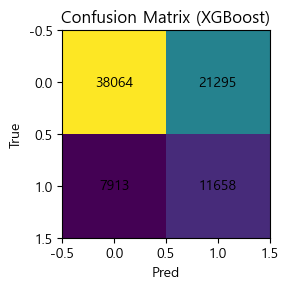

In [27]:
cm = best_metrics["confusion_matrix"]
plt.figure(figsize=(4,3))
plt.imshow(cm)
plt.title(f"Confusion Matrix ({best_name})")
plt.xlabel("Pred")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.show()


In [28]:
from pathlib import Path
import joblib

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODELS_DIR / "best_model.pkl"

joblib.dump(best_pipe, MODEL_PATH)
MODEL_PATH


WindowsPath('models/best_model.pkl')